# Predicting user interactions on a website

 - ### User interactions are highly time dependent, so the problem can be defined as time series analysis. There are many methods to predict interaction, but one of the methods is to use RNN

 - ### This is assumed to be a multiclass classification problem - the user interaction is predicted to belong to only one class among many classes.

## 1. Data preprocessing

### 1.1. Import

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## 1.2. Reding CSV
The first step is to get the data. In this case, the data in the form of a csv file was downloaded from kaggle.com locally to the computer and read. The data is now a Pandas DataFrame object, which allows for easy transformations and conversions.

In [6]:
df = pd.read_csv("clicks.csv")

In [7]:
df.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


# 1.3. Dividing data into values and predictions

 We separate the data into values ​​and expectations. Values ​​marked as "X" describe the data that is the basis for predicting user interactions, based on them we predict what the user will do. DataFrame values ​​:y" describe what we want to predict based on the X value - i.e. the specific user behavior. Separating this data is necessary to train the model and is tested - thanks to this, the model can adapt to better predict the y value based on the X value. To do this, we extract df from the DataFrame containing the X and y data.
 

In [9]:
X = df.drop('EventType', axis=1) 
y = pd.DataFrame(df['EventType'], columns=['EventType'])

In [10]:
print("First 5 values from X DataFrame")
display(X.head())

print("First 5 values from y DataFrame")
display(y.head())

First 5 values from X DataFrame


,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,prod_3354,NaN,NaN


First 5 values from y DataFrame


,EventType
0,page_view
1,page_view
2,product_view
3,add_to_cart
4,add_to_cart


## 1.4 Data encoding to number types

When preparing the data we need to convert it to numeric values. First we find the columns with the character string and convert it to numbers

In [12]:
print("Data Types")
display(X.dtypes)

Data Types


UserID         int64
SessionID      int64
Timestamp     object
ProductID     object
Amount       float64
Outcome       object
dtype: object

### 1.4.1 Time column to numbers conversion

First you need to convert the date string to Timestamp format for later processing

In [14]:
X['Timestamp'] = pd.to_datetime(X['Timestamp'])

In [15]:
print("Data Types")
display(X['Timestamp'].dtype)

Data Types


dtype('<M8[ns]')

#### 1.4.1.1 Convert date to number
Let's create two functions to change the timestamp value to unix time and subtract values ​​of this type from a column

In [17]:
def datetime_to_milliseconds(series):
    """Convert column to unix epoch"""
    return (series - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')

def subtract_timestamp_milliseconds(series, timestamp):
    """Substract columns milisecnds and timestamp."""
    timestamp_milliseconds = (timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
    return series - timestamp_milliseconds

Now let's use the function to convert the column to Unix time milliseconds

In [19]:
X['Timestamp']=datetime_to_milliseconds(X['Timestamp']).astype('int64')

#### First 5 values from X DataFrame

In [21]:
display(X.head())

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
0,1,1,1720375226959,NaN,NaN,NaN
1,1,1,1709676060072,NaN,NaN,NaN
2,1,1,1711231690568,prod_8199,NaN,NaN
3,1,1,1710203525495,prod_4112,NaN,NaN
4,1,1,1708900981318,prod_3354,NaN,NaN


#### Data Types in X values

In [23]:
display(X.dtypes)

UserID         int64
SessionID      int64
Timestamp      int64
ProductID     object
Amount       float64
Outcome       object
dtype: object

#### Now we calculate the value of the smallest Unix time value in order to later subtract it from other values ​​in the TimeStamp column in order to better scale the data

In [25]:
min_time = X['Timestamp'].min()
print(min_time)

1704067295004


#### We now subtract the smallest value in the TimeStamp column from the rest of the values ​​in that column in order to minimize the values ​​in that column.

In [27]:
X['Timestamp'] = X['Timestamp']- min_time

#### First 5 values from X DataFrame

In [29]:
display(X.head())

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
0,1,1,16307931955,NaN,NaN,NaN
1,1,1,5608765068,NaN,NaN,NaN
2,1,1,7164395564,prod_8199,NaN,NaN
3,1,1,6136230491,prod_4112,NaN,NaN
4,1,1,4833686314,prod_3354,NaN,NaN


### 1.4.2 Other string columns to numbers conversion

After converting the TimeStamp column, which was special due to the specifics of the problem, we can convert the rest of the columns to numeric values.

To do the conversion you can use LabelEncoder from Scikit-learn - it will convert repeating strings to numbers - each string will be represented by a specific number.

In [31]:
le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col].astype(str))

In [32]:
print("First 5 values from X DataFrame")
display(X.head())

First 5 values from X DataFrame


,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
0,1,1,16307931955,0,NaN,0
1,1,1,5608765068,0,NaN,0
2,1,1,7164395564,7002,NaN,0
3,1,1,6136230491,3030,NaN,0
4,1,1,4833686314,2298,NaN,0


## 1.4.3. Converting expected values ​​- y - to numbers

The goal of prediction is to find one of many possible expected values ​​- the predicted value belongs to only one element from the set of possible predictions.

The first step is to find the set of all possible events that can be predicted in a given problem. In this case, it is the set of all possible user actions that we intend to predict.

In [34]:
y['EventType'] = y['EventType'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

event_types = y['EventType'].values

unique_event_types = np.unique(event_types)

print(unique_event_types)

['add_to_cart' 'click' 'login' 'logout' 'page_view' 'product_view'
 'purchase']


#### We get a dictionary containing unique values ​​and subsequent indexes

In [36]:
event_type_to_index = {event_type: index for index, event_type in enumerate(unique_event_types)}
print(event_type_to_index)

{'add_to_cart': 0, 'click': 1, 'login': 2, 'logout': 3, 'page_view': 4, 'product_view': 5, 'purchase': 6}


#### These lines of code transform a list of event types into a tensor containing numeric indices

In [38]:
event_indices = torch.tensor([event_type_to_index[event_type] for event_type in event_types])
print(event_indices)

tensor([4, 4, 5,  ..., 2, 6, 3])


#### Assigning events to a list with zeros meaning no event and ones meaning a specific event

Reult is an Tensor

In [40]:
encoded_tensor = F.one_hot(event_indices, num_classes=len(unique_event_types))
print(encoded_tensor)

tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0]])


#### Converting Tensor to Python List

In [42]:
encoded_list = encoded_tensor.tolist()
print(len(encoded_list))
print(encoded_list[0])

74817
[0, 0, 0, 0, 1, 0, 0]


#### Assign Python List with encoded events to DataFrame column

In [44]:
y['EventType'] = encoded_list
y.head()

,EventType
0,"[0, 0, 0, 0, 1, 0, 0]"
1,"[0, 0, 0, 0, 1, 0, 0]"
2,"[0, 0, 0, 0, 0, 1, 0]"
3,"[1, 0, 0, 0, 0, 0, 0]"
4,"[1, 0, 0, 0, 0, 0, 0]"


## 1.5. Scaling data

In order to process the data efficiently, you need to scale the numeric values ​​so that there is not much difference between the values ​​- so as not to "favor" certain columns with values

In [46]:
timestamp_scaler = StandardScaler()
product_id_scaler = StandardScaler()
amount_scaler = StandardScaler()
outcome_scaler = StandardScaler()

# Skalowanie danych
X['Timestamp'] = timestamp_scaler.fit_transform(X[['Timestamp']])
X['ProductID'] = product_id_scaler.fit_transform(X[['ProductID']])
X['Amount'] = amount_scaler.fit_transform(X[['Amount']])
X['Outcome'] = outcome_scaler.fit_transform(X[['Outcome']])
X.fillna(0, inplace=True)

In [47]:
X.head()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
0,1,1,1.446026,-0.690755,0.0,-0.408111
1,1,1,-0.639453,-0.690755,0.0,-0.408111
2,1,1,-0.336230,1.875891,0.0,-0.408111
3,1,1,-0.536640,0.419919,0.0,-0.408111
4,1,1,-0.790532,0.151597,0.0,-0.408111


In [48]:
X.describe()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
count,74817.000000,74817.000000,7.481700e+04,7.481700e+04,7.481700e+04,7.481700e+04
mean,500.740741,5.509777,8.338433e-17,-1.106409e-17,-4.252316e-17,-8.879766e-17
std,288.945183,2.869337,1.000007e+00,1.000007e+00,3.778584e-01,1.000007e+00
min,1.000000,1.000000,-1.732713e+00,-6.907549e-01,-1.734219e+00,-4.081114e-01
25%,251.000000,3.000000,-8.705337e-01,-6.907549e-01,0.000000e+00,-4.081114e-01
50%,501.000000,6.000000,2.499970e-03,-6.907549e-01,0.000000e+00,-4.081114e-01
75%,751.000000,8.000000,8.660787e-01,6.618475e-01,0.000000e+00,-4.081114e-01
max,1000.000000,10.000000,1.726858e+00,2.515536e+00,1.725367e+00,2.450311e+00


## 1.6 Prepare data to loading into model

#### 1.6.1. Dividing data into training and test

In [51]:
input_train, input_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1.6.2. Preparing Dataset class to loading a data

In [53]:
class EventDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)  
        label = torch.tensor(self.labels.iloc[idx].item(), dtype=torch.float32)  
        return sample, label

#### 1.6.3. Preparing datasets and dataloaders

In [55]:
train_dataset = EventDataset(input_train, target_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = EventDataset(input_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [56]:
input_test.head()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
30862,414,3,-0.030110,-0.690755,0.000000,-0.408111
21696,292,1,1.601829,-0.690755,0.000000,-0.408111
54163,725,3,-0.489833,-0.314299,0.316822,2.450311
14463,193,9,0.747261,-0.337026,0.000000,-0.408111
63524,850,7,0.798924,-0.690755,0.000000,-0.408111


In [57]:
input_test.describe()

,UserID,SessionID,Timestamp,ProductID,Amount,Outcome
count,14964.000000,14964.000000,14964.000000,14964.000000,14964.000000,14964.000000
mean,499.919407,5.512563,-0.007671,0.003390,-0.002384,0.008885
std,287.330171,2.877092,0.994691,1.001173,0.379604,1.009026
min,1.000000,1.000000,-1.732187,-0.690755,-1.728077,-0.408111
25%,253.000000,3.000000,-0.872808,-0.690755,0.000000,-0.408111
50%,499.000000,6.000000,-0.014781,-0.690755,0.000000,-0.408111
75%,746.000000,8.000000,0.847633,0.667346,0.000000,-0.408111
max,1000.000000,10.000000,1.726773,2.515169,1.723911,2.450311


# 2.0 Prepering model

### 2.1. Prepareing model class

In [60]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Stan początkowy
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Ostatni krok sekwencji
        return out


### 2.2. Preparing model instance

#### 2.2.1. Prepare parameters

In [63]:
input_size = input_train.shape[1]  # Liczba cech wejściowych
hidden_size = 64  # Liczba neuronów w warstwie ukrytej
output_size = 7  # Liczba klas
num_layers = 1

#### 2.2.2. Model instance

In [65]:
model = RNNModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()  # Ponieważ targety są klasyfikacją wieloklasową
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3.0 Trening and testing

#### 3.1. Trening

In [68]:
num_epochs = 10
losses = []
accuracies = []

model.train()

for epoch in range(num_epochs):

    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_dataloader:
        inputs_reshaped = inputs.unsqueeze(1)
        targets = targets.squeeze(1)

        optimizer.zero_grad()
        outputs = model(inputs_reshaped)

        if targets.dim() > 1:
            targets = torch.argmax(targets, dim=1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    epoch_loss = total_loss / len(train_dataloader)
    epoch_accuracy = 100 * correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1, Loss: 1.3440, Accuracy: 37.27%
Epoch 2, Loss: 1.1092, Accuracy: 41.41%
Epoch 3, Loss: 1.0843, Accuracy: 41.77%
Epoch 4, Loss: 1.0783, Accuracy: 41.59%
Epoch 5, Loss: 1.0685, Accuracy: 41.97%
Epoch 6, Loss: 1.0651, Accuracy: 42.24%
Epoch 7, Loss: 1.0607, Accuracy: 42.35%
Epoch 8, Loss: 1.0554, Accuracy: 42.36%
Epoch 9, Loss: 1.0628, Accuracy: 42.46%
Epoch 10, Loss: 1.0580, Accuracy: 42.18%


#### 3.1.1. Model trening plots

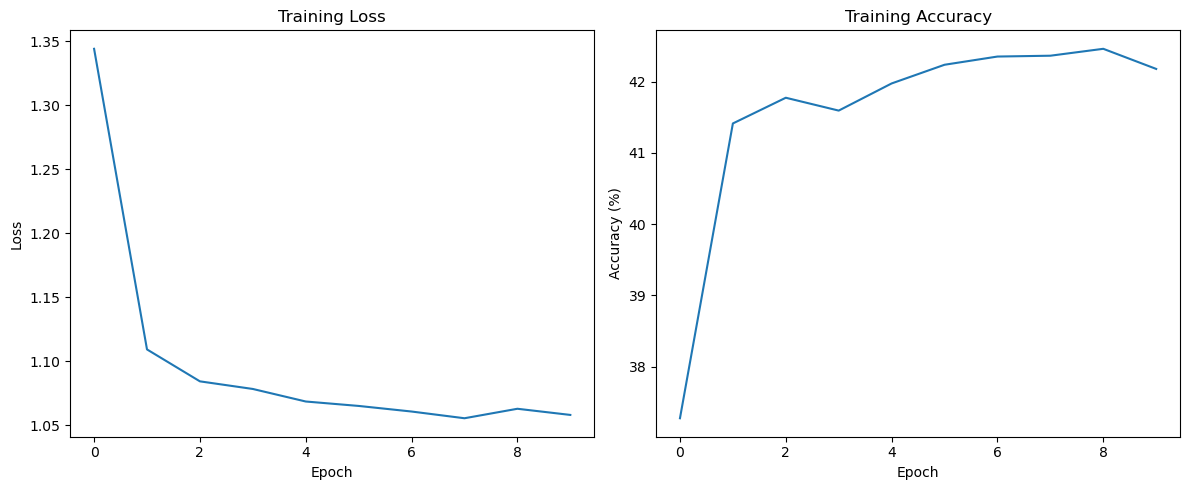

In [70]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

### 3.2. Model testing

In [72]:
model.eval()

correct = 0
total = 0
accuracies = []
all_targets = []
all_probs = []


with torch.no_grad(): 
    for inputs, targets in test_dataloader:
        inputs_reshaped = inputs.unsqueeze(1)
        targets = targets.squeeze(1)

        outputs = model(inputs_reshaped)
        _, predicted = torch.max(outputs, 1)

        targets = torch.argmax(targets, dim=1) 

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy() 
        all_probs.extend(probs)
        all_targets.extend(targets.cpu().numpy())


all_targets = np.array(all_targets)
all_probs = np.array(all_probs)
n_classes = all_probs.shape[1]
binarized_targets = label_binarize(all_targets, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_targets[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



#### 3.2.1. Model testing result

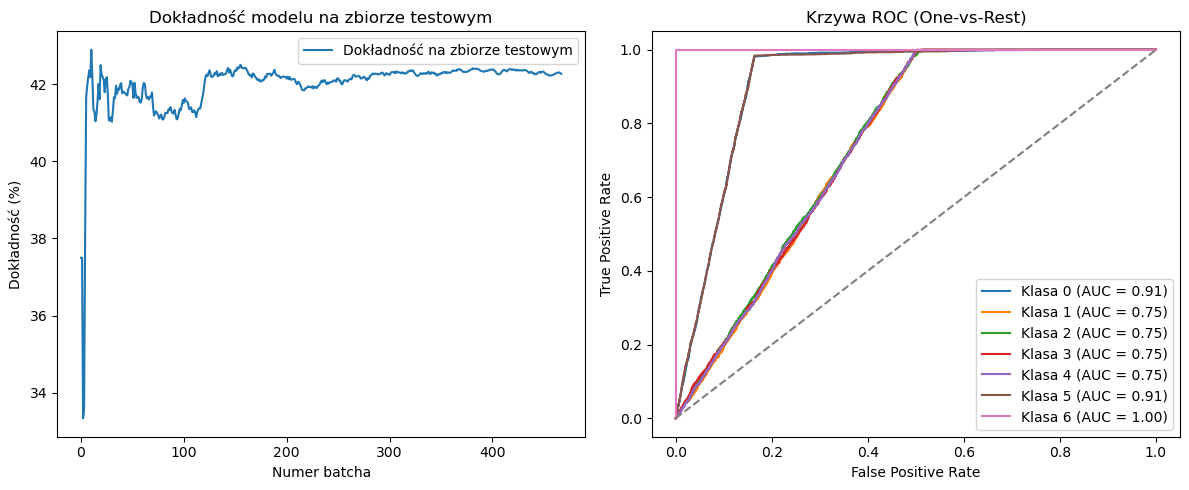

In [74]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(accuracies, label="Dokładność na zbiorze testowym")
plt.xlabel("Numer batcha")
plt.ylabel("Dokładność (%)")
plt.title("Dokładność modelu na zbiorze testowym")
plt.legend()

plt.subplot(1, 2, 2)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Klasa {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Krzywa ROC (One-vs-Rest)")
plt.legend()

plt.tight_layout()
plt.show()